In [1]:
def generate_conversion_rate(prices):
    val = np.random.rand(len(prices))
    conversion_rates = np.sort(val)[::-1]
    return conversion_rates

In [2]:
import matplotlib.pyplot as plt
from mab.environment import *
from mab.ts_learner import *
from mab.ucb_learner import *

n_experiments = 365
n_classes = 4
                    
prices1 = np.cumsum(np.linspace(100,300, num=6))
prices2 = np.array([300])
discounts = np.array([0.0, 0.5, 0.10, 0.25])


conv_rate1 = np.array([generate_conversion_rate(prices1) for x in range(n_classes)])
conv_rate2 = generate_conversion_rate(range(n_classes))
np.random.shuffle(conv_rate2)
conv_rate2 = np.reshape(conv_rate2, (4,1))

arms = prices1 + conv_rate2*prices2


In [3]:
customerParams = zip([25, 25, 25, 25], [10,10,10,10])
conv2_arm = np.linspace(0.1, 1, num=7)
env = Environment(customerParams, discounts, prices1, conv_rate1, conv_rate2)

ts_learner =TS_Learner(arms=arms, arm_conv_rate2=conv2_arm)      
u_learner = UCB(arms=arms)

ts_rewards_all = []
u_rewards_all = []
c_rewards_all = []

for day in range(n_experiments):
    conv2_chosen = conv2_arm[ts_learner.pull_conv_2()]
    #choose the prices for the day
    arms = prices1 + conv2_chosen*prices2 

    ts_rewards_per_experiment = [] 
    u_rewards_per_experiment = []
    c_rewards_per_experiment = []
    
    #At the beginning of the day we know how many customers we are facing
    customerParams = zip([25, 25, 25, 25], [10,10,10,10])
    env.update_customers(customerParams)

    customers = [[(c, cust) for cust in range(size)] for c, size in enumerate(env.customers)]
    customers = [item for sublist in customers for item in sublist]
    random.shuffle(customers) #Shuffling clients avoids biased learners towards the first class

    #pull the prices for the day for TS and UCB considering the amount of customers per class seen so far
    ts_pulled_arm = ts_learner.pull_arm_unkown_cust()
    u_pulled_arm = u_learner.pull_arm_unkown_cust()

    for cust in customers:
        #Pulls without considering the amount of customers per class
        ts_reward = env.round1(ts_pulled_arm, cust)#Rounds considering the ACTUAL customer class
        ts_learner.update(ts_pulled_arm, ts_reward, cust[0])
        
        ts_rewards_per_experiment.append(np.array(arms)[cust[0], ts_pulled_arm[1]]*np.array(ts_reward))

        u_reward = env.round1(u_pulled_arm, cust)#Rounds considering the ACTUAL customer class
        u_learner.update(u_pulled_arm, u_reward, cust[0])

        u_rewards_per_experiment.append(np.array(arms)[cust[0], u_pulled_arm[1]]*np.array(u_reward))

        #Maximum expected reward for a client obtainable from a member of class cust[0]
        c_rewards_per_experiment.append(np.max(conv_rate1[cust[0]]*prices1 + conv_rate2[cust[0]]*prices2))
    
    ts_rewards_all.append(ts_rewards_per_experiment)
    u_rewards_all.append(u_rewards_per_experiment)
    c_rewards_all.append(c_rewards_per_experiment)

Text(0, 0.5, 'Cumulative Mean Reward')

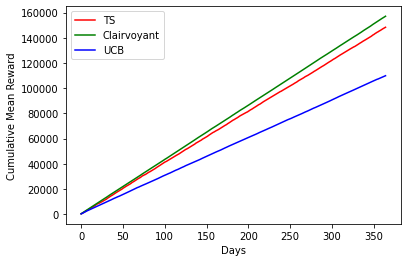

In [4]:
ts_plot = np.array([np.mean(x) for x in ts_rewards_all])
c_plot = np.array([np.mean(x) for x in c_rewards_all])
u_plot = np.array([np.mean(x) for x in u_rewards_all])

plt.plot(np.cumsum(ts_plot), color='red', label='TS')
plt.plot(np.cumsum(c_plot), color='green', label='Clairvoyant')
plt.plot(np.cumsum(u_plot), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Cumulative Mean Reward')

Text(0, 0.5, 'Mean Reward')

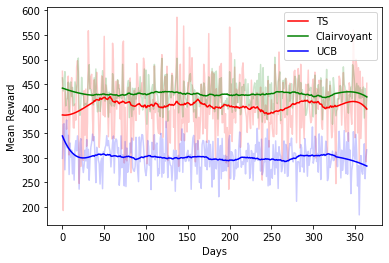

In [5]:
from scipy.signal import savgol_filter

plt.plot(ts_plot, color='red', alpha=0.2)
plt.plot(c_plot, color='green', alpha=0.2)
plt.plot(u_plot, color='blue',alpha=0.2)

plt.plot(savgol_filter(ts_plot, 75, 3), color='red', label='TS') #Cubic interpolation
plt.plot(savgol_filter(c_plot, 75, 3), color='green',label='Clairvoyant')
plt.plot(savgol_filter(u_plot, 75, 3), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Mean Reward')

Text(0, 0.5, 'Regret')

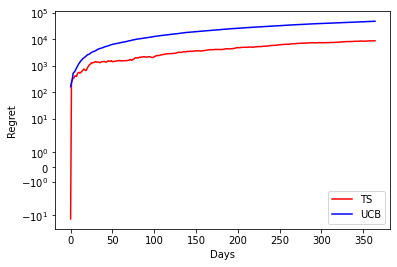

In [6]:
plt.plot(np.cumsum(c_plot - ts_plot), color='red', label='TS')
plt.plot(np.cumsum(c_plot - u_plot), color='blue', label='UCB')

plt.legend()
plt.yscale('symlog') #This might be cheating...
plt.xlabel('Days')
plt.ylabel('Regret')